In [1]:
import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import FunctionTransformer as FT

from lib.Models import UciAdultsClassifier
from lib.Datasets import TabularDataset
from lib.Transformers import NumericFeature, CategoricalFeature, DatasetTransformer

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
columns=[
    'age', 
    'workclass', 
    'fnlwgt', 
    'education', 
    'education-num',
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex',
    'capital-gain', 
    'capital-loss', 
    'hours-per-week', 
    'native-country',
    'income']
adult_train_df = pd.read_csv('adult_train.csv', sep=",", header=None, names=columns)
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

32,561 registros a las 2020-09-06 01:18:41.396928


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_test_df = pd.read_csv('adult_test.csv', sep=",", header=None, names=columns)
print('{0:,} registros a las {1}'.format(len(adult_test_df), datetime.now()))
adult_test_df.head()

16,281 registros a las 2020-09-06 01:18:41.489929


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [4]:
adult_train_df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [5]:
categorical_columns = ['occupation', 'workclass', 'native-country', 'marital-status', 'race', 'relationship', 'sex'] 
continius_columns = ['age', 'capital-gain', 'education-num', 'hours-per-week', 'capital-loss']

q_categorical_columns = len(categorical_columns)
q_continius_columns = len(continius_columns)
q_categorical_columns, q_continius_columns

(7, 5)

In [6]:
X_columns = categorical_columns + continius_columns
Y_column = ['income']
X_ndarray = adult_train_df[X_columns].to_numpy()
X_ndarray, X_ndarray.shape

(array([[' Adm-clerical', ' State-gov', ' United-States', ..., 13, 40, 0],
        [' Exec-managerial', ' Self-emp-not-inc', ' United-States', ...,
         13, 13, 0],
        [' Handlers-cleaners', ' Private', ' United-States', ..., 9, 40,
         0],
        ...,
        [' Adm-clerical', ' Private', ' United-States', ..., 9, 40, 0],
        [' Adm-clerical', ' Private', ' United-States', ..., 9, 20, 0],
        [' Exec-managerial', ' Self-emp-inc', ' United-States', ..., 9,
         40, 0]], dtype=object),
 (32561, 12))

In [7]:
Y_ndarray = adult_train_df[Y_column].to_numpy()
Y_ndarray

array([[' <=50K'],
       [' <=50K'],
       [' <=50K'],
       ...,
       [' <=50K'],
       [' <=50K'],
       [' >50K']], dtype=object)

In [8]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_ndarray, Y_ndarray, test_size = 0.2, random_state = 7)

In [9]:
def replace(data:list, replacements:dict):
    replacements_keys = list(replacements.keys())
    _data = data.copy()
    for i, item in enumerate(_data):
        _data[i] = replacements[item] if item in replacements_keys else _data[i]
        
    return _data

def trim(data:list):
    return np.array([level.strip() for level in data])    

In [10]:
replacement_args = {'replacements': {'?':'N/A'}}
target_replacement_args = {'replacements': {' <=50K':0, ' <=50K.':0, ' >50K':1, ' >50K.':1}}

dataset_tranformer = DatasetTransformer([
    # Categorical features
    ('occupation', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('workclass', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('native-country', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('marital-status', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('race', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('relationship', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('sex', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    
    # Numerical features
    ('age', NumericFeature()),
    ('capital-gain', NumericFeature()),
    ('education-num', NumericFeature()),
    ('hours-per-week', NumericFeature()),
    ('capital-loss', NumericFeature())],
    
    # Target
    ('income', CategoricalFeature([FT(replace, kw_args=target_replacement_args)], False))
)

In [11]:
numerical_features_train, categorical_features_train, target_train = dataset_tranformer.fit_transform(X_train, Y_train)

In [12]:
numerical_features_test, categorical_features_test, target_test = dataset_tranformer.transform(X_test, Y_test)

In [13]:
numerical_features_val, categorical_features_val, target_val = dataset_tranformer.transform(
    adult_test_df[X_columns].to_numpy(), 
    adult_test_df[Y_column].to_numpy()
)

Datasets

In [14]:
train_ds = TabularDataset(
    continius_features=numerical_features_train, 
    categorical_features=categorical_features_train, 
    y=target_train
)

test_ds = TabularDataset(
    continius_features=numerical_features_test, 
    categorical_features=categorical_features_test, 
    y=target_test
)

validation_ds = TabularDataset(
    continius_features=numerical_features_val, 
    categorical_features=categorical_features_val, 
    y=target_val
)

In [15]:
for i in range(10):
    x_continius, x_categorical, y = train_ds[i]
    print(f'{i} -> X_continius: {x_continius[:4]}, X_categorical: {x_categorical[:4]} Y: {y}')

0 -> X_continius: tensor([ 0.9081, -0.1451, -0.0321, -0.0327]), X_categorical: tensor([ 5,  4, 19,  0]) Y: tensor([0.])
1 -> X_continius: tensor([ 0.9081, -0.1451,  1.5151,  0.7742]), X_categorical: tensor([12,  0,  7,  6]) Y: tensor([1.])
2 -> X_continius: tensor([-1.2877, -0.1451,  0.3547, -0.0327]), X_categorical: tensor([ 2,  4, 38,  4]) Y: tensor([0.])
3 -> X_continius: tensor([-0.9949, -0.1451, -0.0321, -1.3237]), X_categorical: tensor([12,  4, 38,  4]) Y: tensor([0.])
4 -> X_continius: tensor([ 0.6885, -0.1451,  1.1283, -0.1941]), X_categorical: tensor([ 0,  4, 38,  0]) Y: tensor([1.])
5 -> X_continius: tensor([-0.7022, -0.1451, -0.0321, -2.6148]), X_categorical: tensor([ 7,  2, 38,  0]) Y: tensor([0.])
6 -> X_continius: tensor([ 0.2493, -0.1451, -0.0321,  0.3708]), X_categorical: tensor([ 7,  2, 38,  4]) Y: tensor([0.])
7 -> X_continius: tensor([-0.5558, -0.1451, -0.4189,  0.7742]), X_categorical: tensor([12,  4, 38,  2]) Y: tensor([1.])
8 -> X_continius: tensor([ 0.7617, -0.14

Dataloaders

In [16]:
train_dl = DataLoader(train_ds, batch_size=1000, shuffle=True)

train_dl_for_prediction = DataLoader(train_ds, batch_size=1000, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)
validation_dl = DataLoader(validation_ds, batch_size=1000, shuffle=False)

In [17]:
for x_continius, x_categorical, y in train_dl:
    print(f'{x_continius.shape}, {x_categorical.shape}, {y.shape}')

torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), to

### Training the net

In [18]:
embedding_dims = []
for column in categorical_columns:
    q_unique_values = len(adult_train_df[column].unique())
    embedding_size = min(q_unique_values//2, 50)
    embedding_dims.append((q_unique_values, embedding_size))

embedding_dims

[(15, 7), (9, 4), (42, 21), (7, 3), (5, 2), (6, 3), (2, 1)]

In [19]:
model = UciAdultsClassifier(q_continius_features=q_continius_columns, q_categorical_features=q_categorical_columns, embedding_dims=embedding_dims)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
bceloss_fn = nn.BCELoss(reduction='mean')
epochs=100

In [20]:
model

UciAdultsClassifier(
  (embeddings_layer): ModuleList(
    (0): Embedding(15, 7)
    (1): Embedding(9, 4)
    (2): Embedding(42, 21)
    (3): Embedding(7, 3)
    (4): Embedding(5, 2)
    (5): Embedding(6, 3)
    (6): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (layer1): Sequential(
    (0): Linear(in_features=46, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Linear(in_feature

In [21]:
losses = model.fit(train_dl=train_dl, epochs=epochs, loss_fn=bceloss_fn, opt=optimizer)

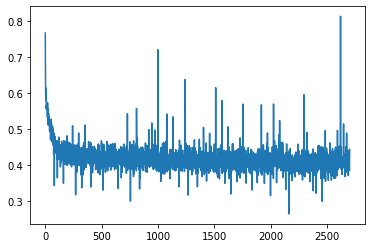

In [22]:
plt.plot(range(len(losses)), losses)

In [23]:
x_continius_train, x_categorical_train, y_train = train_ds.reverse_transform()

In [24]:
x_continius_test, x_categorical_test, y_test = test_ds.reverse_transform()

In [25]:
x_continius_val, x_categorical_val, y_val = validation_ds.reverse_transform()

### Validating the net

In [26]:
y_train_pred = model.predict(train_dl_for_prediction).numpy().squeeze()

In [27]:
y_test_pred = model.predict(test_dl).numpy().squeeze()

In [28]:
y_val_pred = model.predict(validation_dl).numpy().squeeze()

#### Training

In [29]:
aucroc_train = roc_auc_score(y_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.9131920609299553


In [30]:
accuracy_train = accuracy_score(y_train, [1 if pred >= .5 else 0 for pred in y_train_pred])
print(f'Accuracy in training: {accuracy_train}')

Accuracy in training: 0.8606418918918919


#### Testing

In [31]:
aucroc_test = roc_auc_score(y_test, y_test_pred)
print(f'Auc Roc in test: {aucroc_test}')

Auc Roc in test: 0.880063741180858


In [32]:
accuracy_test = accuracy_score(y_test, [1 if pred >= .5 else 0 for pred in y_test_pred])
print(f'Accuracy in test: {accuracy_test}')

Accuracy in test: 0.8409335175802242


#### Validation

In [33]:
aucroc_val = roc_auc_score(y_val, y_val_pred)
print(f'Auc Roc in test: {aucroc_val}')

Auc Roc in test: 0.8754761995867852


In [34]:
accuracy_val = accuracy_score(y_val, [1 if pred >= .5 else 0 for pred in y_val_pred])
print(f'Accuracy in test: {accuracy_val}')

Accuracy in test: 0.843744241754192


### Saving de objects

In [35]:
model.dumps('NN_2020-08-31_v1.pkl')

In [36]:
dataset_tranformer.dumps('DS_Transformer_2020-08-31_v1.pkl')